In [6]:
from flask import Flask, render_template, request, redirect
from bs4 import BeautifulSoup
import requests
import urllib2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def get_sal_data(season):
    data_list = []
    cap = requests.get('http://www.spotrac.com/nba/cap/'+str(season)+'/')
    soup= BeautifulSoup(cap.text,"html.parser")
    table = soup.find('div',{'id':'main','class':' xlarge'}).find()
    sal_cap = str(table)[int(str(table).find('$')+1):int(str(table).find('<br>'))]
    cap_value = float(sal_cap.replace(',',''))/10000
    for pos in ['point-guard','shooting-guard','small-forward','power-forward','center']:
        pos_num = ['point-guard','shooting-guard','small-forward','power-forward','center'].index(pos)
        contract = requests.get('http://www.spotrac.com/nba/rankings/'+str(season)+'/cap-hit/'+pos+'/')
        soup_new= BeautifulSoup(contract.text,"html.parser")
        table = soup_new.find('table',{'class':'datatable noborder'})
        l = table.tbody.find_all('tr')

        for i in l:
            row = [j.get_text().encode('utf-8') for j in i.find_all('td')]
            name = row[2].split('\n')[1]
            sal = int(int(row[3].split('$')[1].replace(',',''))/10000)
            ratio = float(sal)/cap_value
            data_list.append([name,int(pos_num+1),sal,ratio])
    return data_list

In [3]:
def get_player_data(year):
    advanced_train = 'http://www.basketball-reference.com/leagues/NBA_'+str(year)+'_advanced.html'
    req = requests.get(advanced_train)
    text = BeautifulSoup(req.text, 'html.parser')
    stats = text.find('div',{'id': 'all_advanced_stats'})
    per_data = {}
    age_data = {}
    min_data = {}
    wS_data = {}
    for i in stats.tbody.find_all('tr'):

        row = [j.get_text().encode('utf-8') for j in i.find_all('td')]

        if len(row)==0:
            continue
        mins = row[5]
        gp = row[4]
        mp = float(mins)/float(gp)
        age = int(row[2])
        if mp > 5.0 and age>24:
            name = str(row[0])
            per = float(row[6])
            wS = float(row[21])
            if name not in per_data.keys() and per>=0 and wS>=0:
                per_data.update({name:per})
                age_data.update({name:age})
                min_data.update({name:mp})
                wS_data.update({name:wS})
    return per_data,age_data,min_data,wS_data

In [5]:
#current factors include veteran rookie status, train models for five positions separately

In [49]:
plotting_data = []
knn_test = []
test_data = [[],[],[],[],[]]
test_names = [[],[],[],[],[]]
cul_data = [[],[],[],[],[]]
names_data = [[],[],[],[],[]]
for season in [2013,2014,2015,2016]:
    year = season+1
    data_list = get_sal_data(season)
    per_data,age_data,min_data,wS_data = get_player_data(year)
    for player in data_list:
        name = player[0]
        pos = player[1]
        salary = player[2]
        ratio = player[3]
        if name in per_data.keys() and salary>10:
            PER = per_data[name]
            WS = wS_data[name]
            age = age_data[name]
            vet = int(age>=35)
            roo = int(age<=25)
            mp = min_data[name]
            cul_data[pos-1].append([salary,ratio,mp,PER,PER**2,PER**3,WS,WS/mp,vet,roo,mp*PER,age])
            names_data[pos-1].append(name)
            plotting_data.append([PER,WS,ratio])
t_season = 2017
t_year = 2018
data_test = get_sal_data(t_season)
per_test,age_test,min_test,wS_test = get_player_data(t_year)

for player in data_test:
        name = player[0]
        pos = player[1]
        salary = player[2]
        ratio = player[3]
        if name in per_test.keys() and salary>10:
            PER = per_test[name]
            age = age_test[name]
            WS = wS_test[name]
            vet = int(age>=35)
            roo = int(age<=25)
            mp = min_test[name]
            test_data[pos-1].append([salary,ratio,mp,PER,PER**2,PER**3,WS,WS/mp,vet,roo,mp*PER,age])
            test_names[pos-1].append(name)
            knn_test.append([PER,WS,ratio])

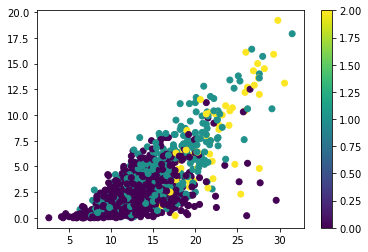

In [54]:
#classification analysis
PER_ = np.array(plotting_data)[:,0]
WS_ = np.array(plotting_data)[:,1]
trainX = np.array(plotting_data)[:,0:2]
X_ = np.array(knn_test)[:,0:2]
y_ = np.array(knn_test)[:,2]
y_class = (y_>0.1)*1+(y_>0.25)*1
sal_ = np.array(plotting_data)[:,2]
sal_ind = (sal_>0.1)*1+(sal_>0.25)*1
plt.scatter(PER_,WS_,c=sal_ind)
plt.colorbar()

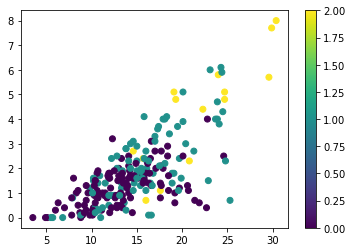

In [55]:
plt.scatter(X_[:,0],X_[:,1],c=y_class)
plt.colorbar()

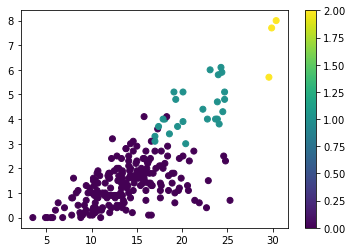

In [107]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=27)
neigh.fit(trainX, sal_ind)
train_pred = neigh.predict(trainX)
classified = neigh.predict(X_)
plt.scatter(X_[:,0],X_[:,1],c=classified)
plt.colorbar()

In [108]:
#training accuracy
print sum((train_pred-sal_ind)==0)*1.0/len(sal_ind)
#testing accuracy
print sum((classified-y_class)==0)*1.0/len(y_class)

0.713279678068
0.627705627706


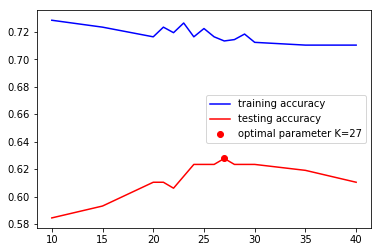

In [106]:
#grid search
train_list = []
test_list = []
K_list = [10,15,20,21,22,23,24,25,26,27,28,29,30,35,40]
for K in K_list:
    neigh = KNeighborsClassifier(n_neighbors=K)
    neigh.fit(trainX, sal_ind)
    train_pred = neigh.predict(trainX)
    classified = neigh.predict(X_)
    train_acc = sum((train_pred-sal_ind)==0)*1.0/len(sal_ind)
    test_acc = sum((classified-y_class)==0)*1.0/len(y_class)
    train_list.append(train_acc)
    test_list.append(test_acc)
opt_k = K_list[test_list.index(max(test_list))]
plt.plot(K_list,train_list,'b',label='training accuracy')    
plt.plot(K_list,test_list,'r',label='testing accuracy')
plt.plot(opt_k,max(test_list),'ro',label='optimal parameter K='+str(opt_k))
plt.legend()


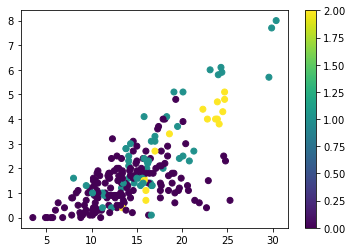

In [131]:
#DCT
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=12)
clf = clf.fit(trainX, sal_ind)
trainY = clf.predict(trainX)
Y_ = clf.predict(X_)
plt.scatter(X_[:,0],X_[:,1],c=Y_)
plt.colorbar()

In [132]:
#training accuracy
print sum((trainY-sal_ind)==0)*1.0/len(sal_ind)
#testing accuracy
print sum((Y_-y_class)==0)*1.0/len(y_class)

0.916498993964
0.580086580087


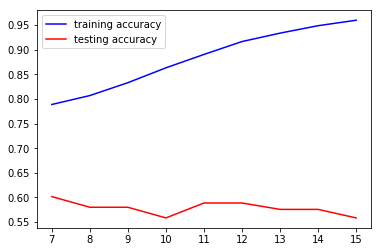

In [124]:
train_list = []
test_list = []
depth_list = [7,8,9,10,11,12,13,14,15]
for depth in depth_list:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(trainX, sal_ind)
    trainY = clf.predict(trainX)
    Y_ = clf.predict(X_)
  
    train_acc = sum((trainY-sal_ind)==0)*1.0/len(sal_ind)
    test_acc = sum((Y_-y_class)==0)*1.0/len(y_class)
    train_list.append(train_acc)
    test_list.append(test_acc)
plt.plot(depth_list,train_list,'b',label='training accuracy')    
plt.plot(depth_list,test_list,'r',label='testing accuracy')
plt.legend()

In [89]:
#prepare data for regression models
i = 2 #select a position 0-PG, 1-SG, 2-SF, 3-PF, 4-C
cur_data = np.array(cul_data[i])
cur_test = np.array(test_data[i])
cur_names = names_data[i]
cur_testname = test_names[i]
Z = cur_data[:,0]
Y = cur_data[:,1]
X = cur_data[:,3:-1]
testX = cur_test[:,3:-1]
testY = cur_test[:,1]
testZ = cur_test[:,0]

In [8]:
from sklearn.linear_model import LinearRegression
#from sklearn.cross_validation import KFold
#kf = KFold(len(Wins),n_folds=5,shuffle=True)
#pred=[]
#test case Memphis Grizzlies

regr = LinearRegression()
    # Iterate through folds
regr.fit(X,Y)

pred = regr.predict(np.array(testX))
 
print "Test R^2 = "+str(regr.score(testX,testY))
print "Train R^2 = "+str(regr.score(X,Y))   
print regr.coef_,regr.intercept_


Test R^2 = 0.496433362135
Train R^2 = 0.666055656437
[ -5.00276369e-02   2.55840950e-03  -4.45193655e-05  -1.54731039e-02
   1.80809550e-01  -6.51857495e-03  -2.37353930e-02   5.67924863e-04] 0.241817694698


In [9]:
pred_show = []
cur_cap = 9909
for i in range(len(cur_testname)):
    name = cur_testname[i]
    per = round(testX[i][0],1)
    age = int(cur_test[i][-1])
    mp = round(cur_test[i][2],1)
    ws = round(testX[i][3],1)
    sal_pred = int(pred[i]*cur_cap)
    true_sal = int(testZ[i])
    pred_show.append([true_sal,sal_pred,name,per,ws,mp,age])
pred_show

[[3328, 3909, 'LeBron James', 30.2, 7.7, 37.2, 33],
 [2624, 1619, 'Carmelo Anthony', 14.6, 2.7, 32.8, 33],
 [2500, 3309, 'Kevin Durant', 24.7, 4.8, 34.7, 29],
 [2311, 837, 'Chandler Parsons', 14.6, 1.1, 21.0, 29],
 [2311, 1845, 'Harrison Barnes', 16.1, 2.1, 34.8, 25],
 [2055, 1323, 'Danilo Gallinari', 10.4, 0.2, 31.7, 29],
 [1950, 2484, 'Paul George', 18.4, 4.1, 36.7, 27],
 [1886, 2106, 'Kawhi Leonard', 25.3, 0.7, 22.6, 26],
 [1719, 747, 'Luol Deng', 5.6, 0.0, 13.0, 32],
 [1691, 1398, 'Kent Bazemore', 14.6, 1.3, 28.3, 28],
 [1669, 1454, 'Robert Covington', 13.8, 2.8, 32.3, 27],
 [1600, 1773, 'Tobias Harris', 17.7, 3.8, 32.8, 25],
 [1481, 877, 'Andre Iguodala', 10.2, 1.6, 26.2, 34],
 [1480, 1243, 'DeMarre Carroll', 13.4, 1.9, 28.8, 31],
 [1413, 1241, 'Joe Ingles', 12.8, 2.5, 30.5, 30],
 [1410, 2379, 'Khris Middleton', 17.0, 3.0, 37.3, 26],
 [1201, 1159, 'Wilson Chandler', 10.2, 1.4, 31.1, 30],
 [1050, 1330, 'Bojan Bogdanovic', 12.6, 1.9, 31.3, 28],
 [1000, 194, 'Jared Dudley', 11.9, 0.5